## Naive MCMC for Estimating Parameters for a Single-Jump Diffusion Model


Assumes that:
+ log price change before the jump follows a Gaussian
+ log price change during the jump follows a Gaussian
+ no. of time steps of the jump is in the interval [1, $\infty$] with strong preference for (0, 10) with very low probability for values greater than 10

More formally, the $i$-th price index at time $t + 1$, $s_i$, can be described by the following:

$$
\begin{align*}
    s_i(t + 1)         &= s_{i}(t) x(t),\\
    s_i(0)             &= 1,\\\\

    \log x(t)          &\sim
                           \begin{cases}
                               \mathcal{N}(\tilde{\mu}_i,\ \tilde{\sigma}_j^2), & \text{if } t_s \le t < t_s + n_i, \\
                               \mathcal{N}(\mu_i,\ \sigma_i^2), & \text{otherwise,}
                           \end{cases}\\\\

    \tilde{\mu}_i      &= \mu_i + \mu_j p_i,\\
    \tilde{\sigma}_j^2 &= \sigma_i^2  + \sigma_j^2 p_i^2, \\\\
    
    \mu_i              &\overset{iid}{\sim} \mathcal{B}(1 \times 10^1, 1 \times 10^3) - 0.005,\\
    \sigma_i           &\overset{iid}{\sim} \mathcal{U}(0, 0.05),\\\\
    
    \mu_j              &\overset{iid}{\sim} \mathcal{B}(1 \times 10^4, 1 \times 10^5),\\
    \sigma_j           &\overset{iid}{\sim} \mathcal{B}(1 \times 10^4, 1 \times 10^6),\\\\

    p_i                &\overset{iid}{\sim} \mathcal{B}(1, 1),\\\\
    
    n_i                &\overset{iid}{\sim} \mathcal{P}(2.5) + 1
\end{align*}
$$

where $\mathcal{N},\ \mathcal{B},\ \mathcal{U},$ and $\mathcal{P}$ are the Normal, Beta, Uniform, and Poisson distributions respectively and

+ $n_i$ is the number of time steps the jump lasts for the $i$-th price index
+ $p_i$ is the proportion of the *jump* effect present during the *jump* period for the $i$-th price index
+ $t_s$ is the time when the jump process starts (fixed for all assets)
+ $\mu_i$ is the mean drift for the $i$-th price index in log space
+ $\sigma_i^2$ is the variance for the $i$-th price index in log space
+ $\mu_j$ is the mean drift for all assets during their jump process
+ $\sigma_j^2$ is the variance for all assets during their jump process

In [1]:
from   matplotlib   import pyplot as plt
from   scipy        import stats

import numpy as np

In [2]:
# M assets with different drifts, volatility and number of time steps for the jump process
M  = 10

# number of parameters per asset
c  = 4

# set seed for reproducibility
np.random.seed(0)

# draw the asset parameters randomly from sensible looking distributions
mu = stats.beta(1e1, 1e3).rvs(M) - 4e-3
sd = stats.uniform(0, 5e-2).rvs(M)
nt = stats.poisson(2.5    ).rvs(M) + 1
pr = stats.beta(10, 1).rvs(M)

# jump parameters (shared amongst all assets)
mu_j, sd_j = stats.beta(5e4, 1e5).rvs(), stats.beta(5, 1e2).rvs()

# solution and two text formats
solution = np.array(sum([list(msnpq) for msnpq in zip(mu, sd, nt, pr)], []) + [mu_j, sd_j])
string   = sum([[f'{s:>3s}_{i}' for s in [' mu', ' sd', 'lam', '  p']] for i in range(1, len(mu) + 1)], []) + [' mu_j', ' sd_j']
latex    = sum([[f'${sym}_{i}$' for sym in [r'\mu', r'\sigma', r'\lambda', 'p']] for i in range(1, len(mu) + 1)], []) + ['$\mu_j$', '$\sigma_j$']

# solution with the sd values in log10 space (optimisation later in log10 space)
log_space = solution.copy()
log_space[1::c] = np.log10(log_space[1::c])

# number of time periods before the jump for each asset
start = 100

def generator(mu, sd, nt, pr, mu_j, sd_j, start = start, after = 20):

    T          = start + nt + after

    mask       = [(start <= i < start + nt) for i in range(T)]

    jump       = np.zeros(T, dtype = float)
    jump[mask] = np.random.normal(mu_j, sd_j, size = nt)

    vol        = np.random.normal(mu  , sd  , size =  T)
    vol[0]     = 0

    index      = np.exp(np.cumsum(vol + jump * pr))

    return index, vol, jump

index, vol, jump = [], [], []

for k, (m, s, n, p) in enumerate(zip(mu, sd, nt, pr)):
    i, v, j = generator(m, s, n, p, mu_j, sd_j)
    index.append(i)
    vol.append(v)
    jump.append(j)

# truncate to the smallest length (still includes the entire jump period)
min_length       = min(map(len, index))
index, vol, jump = map(lambda arrays : np.array([array[:min_length] for array in arrays]), [index, vol, jump])

# data to give to our sampling algorithm (log price change)
data = np.log(np.insert(index[:,1:]/ index[:,:-1], 0, 1, 1))

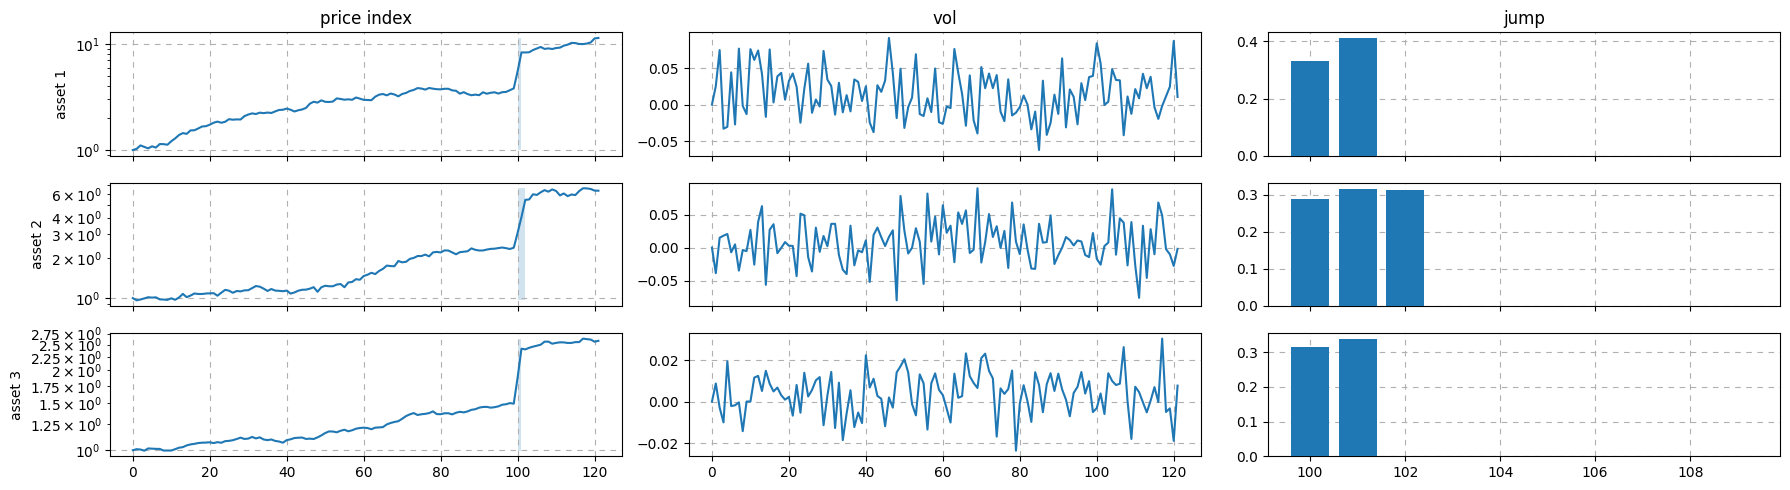

In [3]:
# visualise the first three assets
fig, ax = plt.subplots(3, 3, figsize = (18, 5), sharex = 'col')

for j, title in enumerate(['price index', 'vol', 'jump']):
        ax[0, j].set_title(title)

ymin, ymax = index[:3].min(axis = 1), index[:3].max(axis = 1)
for i, (ind, v, j, m, n) in enumerate(zip(index, vol, jump, mu, nt)):
    ax[i, 0].semilogy(ind)
    ax[i, 0].fill_betweenx([ymin[i], ymax[i]], start, start + n - 1, alpha = 0.2)
    ax[i, 0].set_ylabel(f'asset {i + 1}')

    ax[i, 1].plot(v)

    ax[i, 2].bar(range(100, 110), j[start:start + 10], zorder= 3)

    for j in range(3):
        ax[i, j].grid(ls = (0, (5, 5)))

    if i == 2:
        break

plt.tight_layout()

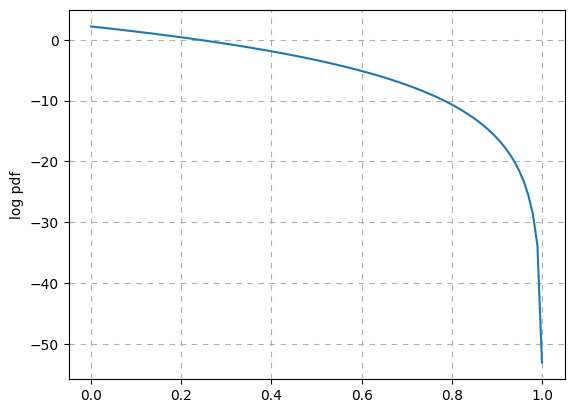

In [4]:
# Choice of priors

# Lets assume a Uniform prior for the jump period in the interval [1, 11]
# Lets assume a Uniform prior for the standard deviations in the interval [0, 0.1]
# ideally both should be more complicated than a Uniform but I choose this for simplicity

# Lets assume a beta prior for log jump returns per time period (mu_j)
xm = np.linspace(0.001, 0.999, 100)

plt.plot(xm, stats.beta(1, 9).logpdf(xm))
plt.ylabel('log pdf')

plt.grid(ls = (0, (5, 5)))

# we prefer a jump drift  towards 0 and increasingly becomes less likely away from 0 
# (bounded, as we further assume price cannot double per time period)

In [5]:
def theta2params(theta):
    """ obtains the parameters from theta (converts the parameters that were in log space) """
    mu, log_sd, lam, pr = (theta[i:-2:c] for i in range(c))
    mu_j, log_sd_j      = theta[-2], theta[-1]

    sd, sd_j   = 10 ** log_sd, 10 ** log_sd_j
    return mu, sd, lam, pr, mu_j, sd_j

def log_data_likelihood(data, theta, start):
    
    # get the parameters from theta
    mu, sd, lam, pr, mu_j, sd_j = theta2params(theta)

    # rounds each lam value to the nearest integer
    nt         = [int(l + 0.5) for l in lam] 

    # masks for jump and vol period (per asset)
    mask_jump  = np.zeros_like(data, dtype = bool)
    mask_vol   = np.ones_like (mask_jump)
    
    # each asset has a different jump mask due to a different nt
    for i, n in enumerate(nt):
        mask_jump[i,start:start + n] = True
        mask_vol [i,start:start + n] = False

    # log probabilities

    p_j, p_v = 0, 0
    for i, (mu_i, sd_i, pr_i) in enumerate(zip(mu, sd, pr)):

        # since the jump period is affected by independent distributions, weight the contributions by pr[i] and qr[i]
        mj   = mu_i + mu_j * pr_i
        sdj  = sd_i + sd_j * pr_i
        p_j += stats.norm.logpdf(data[i,mask_jump[i]], mj  , sdj ).sum()
        p_v += stats.norm.logpdf(data[i,mask_vol [i]], mu_i, sd_i).sum() # independent gaussian for each asset

    # return total log probability
    return p_j + p_v

def uniform_logpdf(a, b, x):
    if ((x < a) | (x > b)).any():
        return -np.inf
    return - len(x) * np.log(b - a)

def log_prior(theta, **kwargs):
    
    # get the parameters from theta
    mu, sd, lam, pr, mu_j, sd_j = theta2params(theta)

    # lazy assumption that mu can be any real number (should really prefer things closer to 0)
    p_mu   = 0

    # lazy prior on all sd values to be U(0, 0.1)
    sd     = np.append(sd, sd_j)
    p_sd   = uniform_logpdf(0, 0.1, sd)

    # lazy prior on the mean jump period to be U(1, 11)
    p_lam  = uniform_logpdf(1, 11, lam)
    
    # lazy prior on the pr values to be in U(0, 1)
    p_pr   = uniform_logpdf(0, 1, pr)
    
    # # lazy prior on the pr values to be in U(0, 1)
    # p_qr   = uniform_logpdf(0, 1, qr)

    # lazy prior on the qr values to be in U(0, 1)
    # p_qr   = stats.uniform(0, 1).logpdf(qr).sum() # + stats.multivariate_normal(lam ** -2, 1e-3).logpdf(pr)

    # beta prior as shown in the previous cell
    p_mu_j = stats.beta(10, 90).logpdf(mu_j)

    return p_mu + p_sd + p_lam + p_pr + p_mu_j

def log_pstar(theta, data, **kwargs):
    # p(theta|data) = p(data|theta) p(theta) / c 
    # for some normalising constant c (hence ignored)
    return log_data_likelihood(data, theta, **kwargs) + log_prior(theta)

def gibbs(log_pstar, theta0, n, data, burn = 0.2, transition = 0.1, random_state = None, verbose = False, **kwargs):

    if random_state is not None:
        # set seed for reproducibility
        np.random.seed(random_state)
        
    # number of elements in a sample
    m       = len(theta0)
    
    # ensures transition is a vector of variances
    if isinstance(transition, (int, float)):
        transition = np.array([transition] * m)
    elif isinstance(transition, (tuple, list)):
        transition = np.array(transition)
    elif transition.ndim == 2:
        # ignore covariances and only use the diagonal variance terms
        transition = np.diag(transition)

    # N is chosen such that:
    #     N = n * (1 + burn)  if burn is a float
    #     N = n + burn        if burn is a int

    if isinstance(burn, float):
        burn = int(n * burn + 0.5)

    N       = n + burn
    N      += 1 # ignore theta0

    acc     = np.zeros((N, m), dtype = bool) # indicator variable for acceptance
    samples = []                             # samples to return
    old     = theta0                         # set the previous sample, old, as the initial theta0
    log     = np.zeros((N, m))               # record of pstar values
    log[0]  = log_pstar(old, data, **kwargs) # assign the first row of pstar values to pstar(old)
    ind     = (0, 0)                         # index of the most current accepted sample

    if verbose:
        if isinstance(verbose, float):
            verbose = int(N * verbose + 0.5)
        print(' iteration | log pstar')
        print('-----------+----------')
        print(f'(burn) {0:3d} | {log[ind]:+.2e}')

    for i in range(1, N):
        for j in range(m):

            # copy the old sample
            new    = old.copy()

            # only sample the j-th element
            new[j] = stats.norm(new[j], transition[j]).rvs()

            # compute pstar
            l      = log_pstar(new, data, **kwargs)

            # check if pstar did not explode
            # accept with p_new / p_old probability
            if np.isfinite(l) and ((l > log[ind]) or ((np.random.uniform() < np.exp(l - log[ind])))):
                old       = new
                ind       = (i, j) # location of the most current pstar value to compare with
                log[i, j] = l      # assign pstar(new)
                acc[i, j] = 1
            else:

                # set the record of pstar values for the (i, j)-th entry to be pstar(old)
                log[i, j] = log[ind]

        # append sample (note that old has been modified in the inner for-loop)
        samples.append(old)

        if verbose:
            print(f'\r{"(burn)" if i <= burn else "      "} {i:3d} | {log[ind]:+.2e}', end = '\n' if i % verbose == 0 else '')
        
    # samples[n, m], rejection indicator [N, m], pstar(all_samples) [N, m] where N > n due to burn-in
    return np.array(samples[burn:]), acc[1:], log

 iteration | log pstar
-----------+----------
(burn)   0 | -3.12e+03
(burn)  15 | +3.14e+03
(burn)  30 | +3.15e+03
(burn)  45 | +3.15e+03
        60 | +3.17e+03
        75 | +3.18e+03
        90 | +3.18e+03
       105 | +3.17e+03
       120 | +3.17e+03
       135 | +3.18e+03
       150 | +3.18e+03


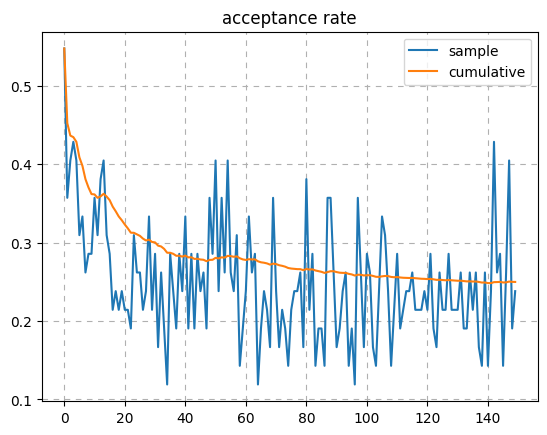

In [6]:
# execute our gibbs sampler with some number of samples, `n`, and a burn-in period, `burn`.
# on my personal (old laptop):
#     takes ~ 2.5 mins with (M, n) = (10, 1000)
#     takes ~10   mins with (M, n) = (75,  100)
# 
# recall `M` is the number of assets at the top of the notebook

# mu_1, log_10(sd_1), lam_1, pr_1, mu_2, log_10(sd_2), lam_2, pr_2, ..., mu_j, log_10(sd_j)
theta0            = np.array([0.0,-2.0, 2.0, 0.7] * len(index) + [0.2,-1.0])

# every parameter of theta0 will change by N(0, 0.1^2) when sampling
transition        = [0.01, 0.2, 1.5, 0.3] * len(data) + [0.2, 1.0]

n                 = 100
burn              =  50
samples, acc, log = gibbs(log_pstar, theta0, n, transition = transition, burn = burn, random_state = 0, data = data, start = start, verbose = 0.1)

# average result
average         = samples.mean(axis = 0)

# as we have an acceptance indicator for each element within a sample
# average across the elements within a sample
accept = acc.mean(axis = 1) 

# visualise acceptance rate
plt.plot(accept, label = 'sample')
plt.plot(accept.cumsum(axis = 0) / np.arange(1, len(accept) + 1), label = 'cumulative')
plt.title('acceptance rate')
plt.grid(ls = (0, (5, 5)))
plt.legend()
plt.show()

In [7]:
# average acceptance rate for mu_i, log_sd_i, lam_i, p_i
print((acc.cumsum(axis = 0) / np.arange(1, len(acc) + 1).reshape(-1, 1))[-1,:-2].reshape(-1,c).mean(axis = 0))

# acceptance rate for mu_j, log_sd_j
print((acc.cumsum(axis = 0) / np.arange(1, len(acc) + 1).reshape(-1, 1))[-1,-2:])

[0.24866667 0.194      0.27866667 0.308     ]
[0.09333333 0.10666667]


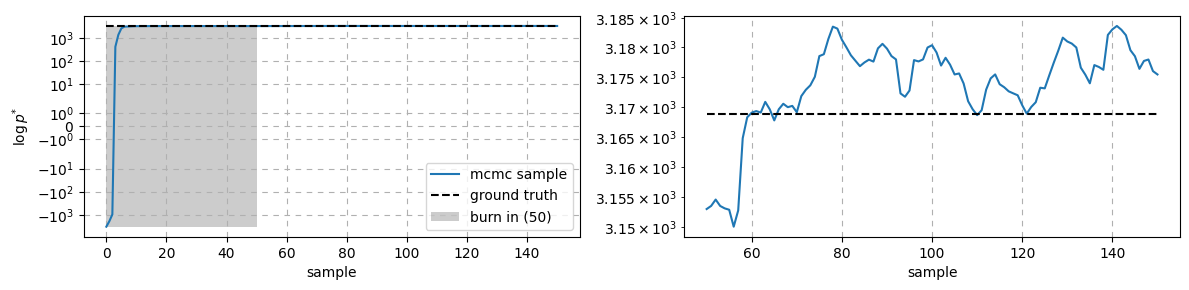

param    |  initial |    truth |  average
---------+----------+----------+---------

 mu_1    |  +0.0000 |  +0.0118 |  +0.0136
 sd_1    |  +0.0100 |  +0.0333 |  +0.0325
lam_1    |  +2.0000 |  +2.0000 |  +2.0282
  p_1    |  +0.7000 |  +0.8618 |  +0.9297

 mu_2    |  +0.0000 |  +0.0130 |  +0.0098
 sd_2    |  +0.0100 |  +0.0335 |  +0.0342
lam_2    |  +2.0000 |  +3.0000 |  +2.9629
  p_2    |  +0.7000 |  +0.9443 |  +0.7915

 mu_3    |  +0.0000 |  +0.0051 |  +0.0034
 sd_3    |  +0.0100 |  +0.0105 |  +0.0100
lam_3    |  +2.0000 |  +2.0000 |  +2.0001
  p_3    |  +0.7000 |  +0.7286 |  +0.7219

 mu_4    |  +0.0000 |  +0.0080 |  +0.0072
 sd_4    |  +0.0100 |  +0.0064 |  +0.0070
lam_4    |  +2.0000 |  +2.0000 |  +1.8666
  p_4    |  +0.7000 |  +0.8993 |  +0.7479

 mu_5    |  +0.0000 |  +0.0069 |  +0.0041
 sd_5    |  +0.0100 |  +0.0158 |  +0.0156
lam_5    |  +2.0000 |  +2.0000 |  +1.9673
  p_5    |  +0.7000 |  +0.9819 |  +0.9253

 mu_6    |  +0.0000 |  +0.0110 |  +0.0106
 sd_6    |  +0.0100 |  +0.01

In [8]:
L = log.mean(axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (12, 3))

ax[0].plot(L, label = r'mcmc sample')
ax[0].set_yscale('symlog')
ax[0].hlines(log_pstar(log_space, data = data, start = start), 0, len(log) - 1, ls = '--', colors = 'k', label = 'ground truth')
ax[0].fill_betweenx([L.min(), L.max()], 0, burn, fc = 'k', alpha = 0.2, label = f'burn in ({burn:,d})')
ax[0].grid(ls = (0, (5, 5)))
ax[0].set_xlabel('sample')
ax[0].set_ylabel(r'$\log p^{*}$')
ax[0].legend()

ax[1].semilogy(range(burn, len(L)), L[burn:])
ax[1].hlines(log_pstar(log_space, data = data, start = start), burn, len(log) - 1, ls = '--', colors = 'k')
ax[1].set_xlabel('sample')
ax[1].grid(ls = (0, (5, 5)))

plt.tight_layout()
plt.show()

print('param    |  initial |    truth |  average')
print('---------+----------+----------+---------')
for i, (text, truth, theta, element) in enumerate(zip(string, solution, theta0, average)):
    q = i % c

    # seperate each set of asset parameters
    if q == 0:
        print()

    # convert the sd values from log10 space
    if q == 1:
        theta   = 10 ** theta
        element = 10 ** element

    print(f'{text:7s}  | {theta:+8.4f} | {truth:+8.4f} | {element:+8.4f}')

# we can observe that we have a lot of samples that are more probable than the ground truth

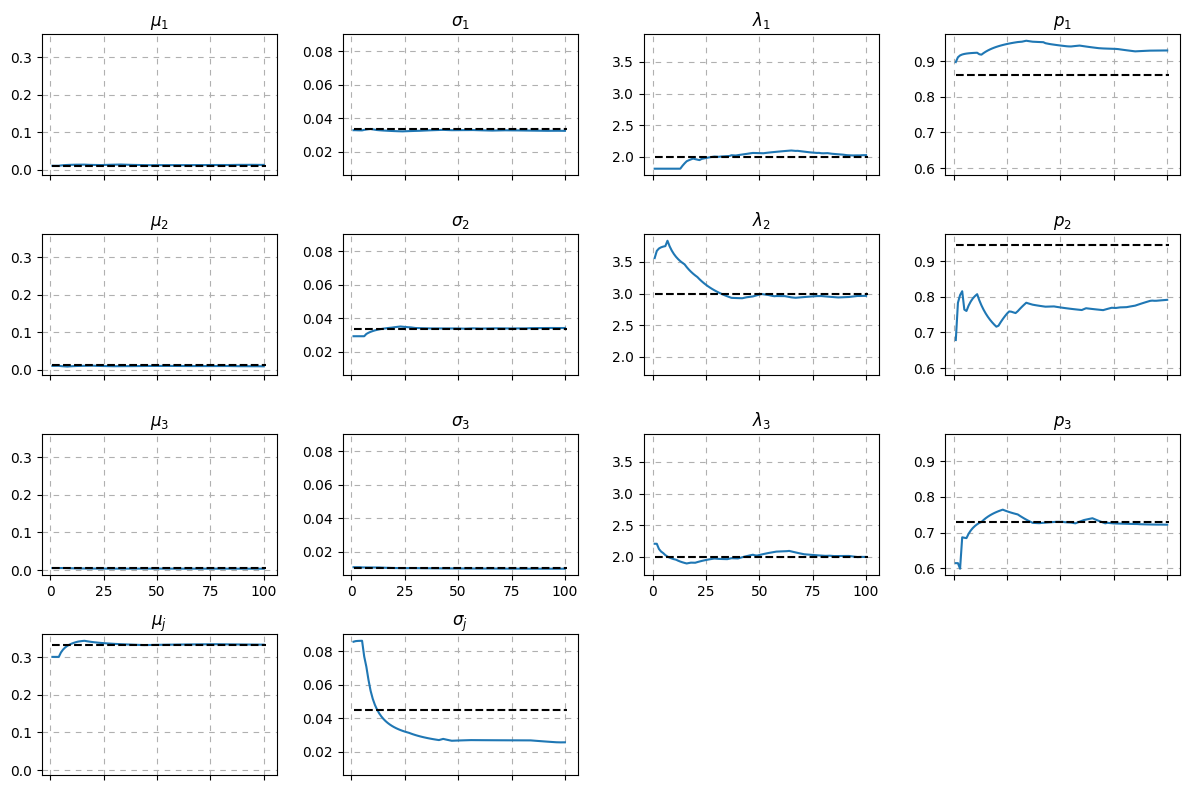

In [9]:
# visualise the first 3 assets only and the jump parameters
fig, ax = plt.subplots(4, c, figsize = (12, 8), sharey = 'col')

x       = np.arange(1, len(samples) + 1)

for k, (values, truth, title) in enumerate(zip(samples.T, solution, latex)):
    i, j = divmod(k, c)
    if k == (3 * c) + 2: break
    if k >= (3 * c):
        i, j = 3, k % (3 * c)
        values = samples[:,j - 2]
        truth  = solution[j - 2]
        title  = latex[j - 2]
    cum_vals = values.cumsum() / x
    if j == 1:
        cum_vals = 10 ** cum_vals
    ax[i, j].plot(x, cum_vals)
    ax[i, j].hlines(truth, 1, len(samples) + 1, ls = '--', colors = 'k')
    ax[i, j].set_title(title)
    ax[i, j].grid(ls = (0, (5, 5)))
    if k not in range(8, 11):
        ax[i, j].set_xticklabels([])

for j in range(c - 2):
    ax[3,-1-j].set_visible(False)

plt.tight_layout()

In [10]:
print('estimate     | pstar(theta|data) | log p(data|theta) |      log p(theta)')
print('-------------+-------------------+-------------------+------------------')
for text, values in zip(['initial', 'mcmc average', 'ground truth'], [theta0, average, log_space]):
    results = ' | '.join(f'{fun(theta = values, data = data, start = start):+17.4e}' for fun in [log_pstar, log_data_likelihood,  log_prior])
    print(f'{text:12s} | {results}')

# we can see that the mcmc obtains a result very close to the ground truth (and obtains a marginally better pstar value)

estimate     | pstar(theta|data) | log p(data|theta) |      log p(theta)
-------------+-------------------+-------------------+------------------
initial      |       -3.1181e+03 |       -3.1187e+03 |       +6.3742e-01
mcmc average |       +3.1870e+03 |       +3.1980e+03 |       -1.1029e+01
ground truth |       +3.1688e+03 |       +3.1796e+03 |       -1.0800e+01


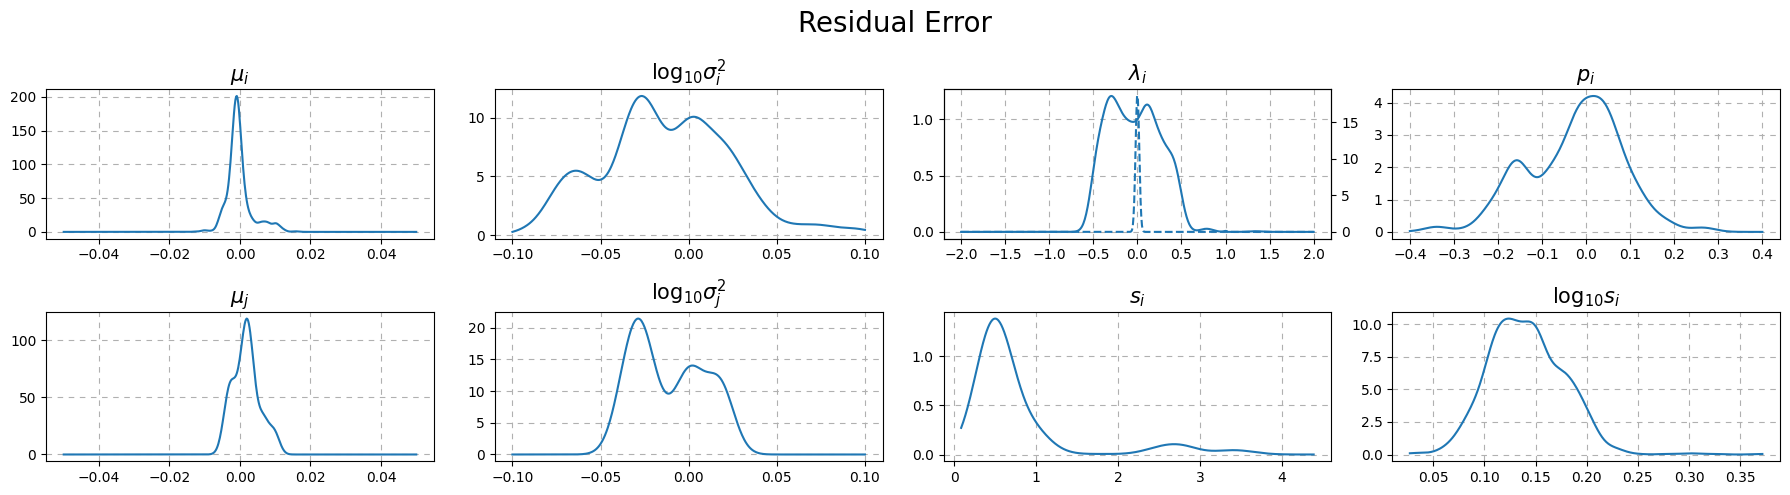

In [11]:
fig, ax = plt.subplots(2, 4, figsize = (18, 5))

titles  = [r'$\mu_i$', r'$\log_{10} \sigma_i^2$', r'$\lambda_i$', r'$p_i$', '$\mu_j$', '$\log_{10} \sigma_j^2$']

for k in range(c * 2):

    i, j = divmod(k, c)

    if i:

        s = samples[:,j]
        t = log_space[j]

    else:

        s = samples[:,j:-2:c]
        t = log_space[j:-2:c]

    if j == 0:
        a, b = -0.05, 0.05
    elif j == 1:
        a, b = -0.1, 0.1
    elif j == 2:
        a, b = -2, 2
    elif j == 3:
        a, b = -0.4, 0.4

    ax[i,j].grid(ls = (0, (5, 5)))

    if k >= len(titles):
        continue

    ax[i,j].set_title(titles[k], size = 15)

    x = np.linspace(a, b, 500)
    y = stats.gaussian_kde((s - t).flatten())(x)

    ax[i,j].plot(x, y)
    
    if j == 2:
        s = np.floor(s + 0.5)
        y = stats.gaussian_kde((s - t).flatten())(x)
        ax[i,j].twinx().plot(x, y, '--')

for i in range(2):
    ax[i,1].set_xticks(np.arange(-0.1, 0.11, 0.05))

# compute residual price index relative to the start of the jump period
move   = samples[:,0:-2:c] + 10 ** samples[:,1:-2:c] / 2 + samples[:,3:-2:c] * (samples[:,-2] + 10 ** samples[:,-1] / 2).reshape(-1, 1)
hatl   = move * np.floor(samples[:,2:-2:c] + 0.5)
hat    = np.exp(hatl)
target = index[(np.arange(len(index)), start + nt)] / index[:,start]
delta  = (hat - target).flatten()
logr   = np.log10(hat / target).flatten()

xd     = np.linspace(delta.min(), delta.max(), 500)
xl     = np.linspace(logr.min(), logr.max(), 500)

ax[1,2].plot(xd, stats.gaussian_kde(delta)(xd))
ax[1,3].plot(xl, stats.gaussian_kde(logr)(xl))

ax[1,2].set_title(r'$s_i$', size = 15)
ax[1,3].set_title(r'$\log_{10} s_i$', size = 15)

plt.suptitle('Residual Error', size = 20)
plt.tight_layout()